In [1]:
from tensorflow.keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

from sklearn.model_selection import KFold
from statistics import mean, stdev

Train: X:(60000, 28, 28) ,y:(60000,)
Test: X:(10000, 28, 28) ,y:(10000,)


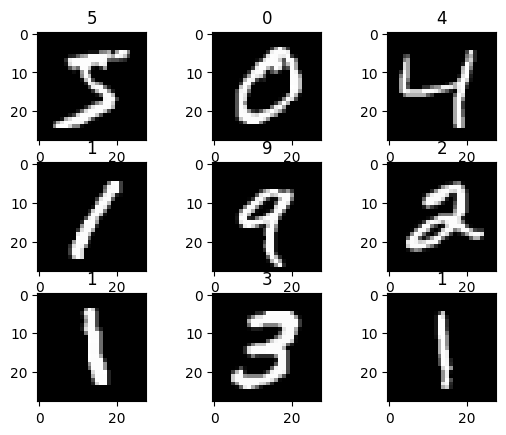

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X:%s ,y:%s' % (trainX.shape, trainy.shape))
print('Test: X:%s ,y:%s' % (testX.shape, testy.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
    plt.title(str(trainy[i]))
plt.show()

In [3]:
def load_data():
    # load data from api
    (trainX, trainy), (testX, testy) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0],  28, 28, 1))

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    return trainX, trainy, testX, testy

In [4]:
def prep_pixels(train, test):
    # we must convert to float to validate divsion
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

In [19]:

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu',
              kernel_initializer='he_uniform', input_shape=(28, 28, 1)))

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu',
              kernel_initializer='he_uniform'))

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))

    opt = SGD(learning_rate=.01, momentum=.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:

def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    kfold = KFold(n_folds, shuffle=True, random_state=1)

    for train_i, test_i in kfold.split(X=dataX):
        model = define_model()
        trainX, trainy, testX, testy = dataX[train_i], dataY[train_i], dataX[test_i], dataY[test_i]

        history = model.fit(trainX, trainy, epochs=10, batch_size=32,
                            validation_data=(testX, testy), verbose=0)
        _, acc = model.evaluate(testX, testy, verbose=0)

        print('> %.3f' % (acc*100))

        histories.append(history)
        scores.append(acc)

    return scores, histories

In [11]:
# plot diagnostic learing curve

def summerize_diagnostic(histories):

    for i in range(len(histories)):

        plt.subplot(2, 1, 1)
        plt.title("Cross Entropy Loss")
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'],
                 color='orange', label='test')

        plt.subplot(2, 1, 2)
        plt.title("Classification Accuracy")
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'],
                 color='orange', label='test')

    plt.show()

In [8]:
def summarize_performance(scores):
    print('Accuracy: mean=%.3f  std=%.3f  n=%d' %
          (mean(scores)*100, stdev(scores) * 100, len(scores)))
    plt.boxplot(scores)
    plt.show()

In [18]:
def run_test_harness():

    trainX, trainy, testX, testy = load_data()
    trainX, testX = prep_pixels(trainX, testX)

    model = define_model()
    model.fit(trainX, trainy, verbose=0, epochs=10, batch_size=32)
    model.save('final_model.h5')

> 98.608
> 98.650
> 98.750
> 98.783
> 98.833


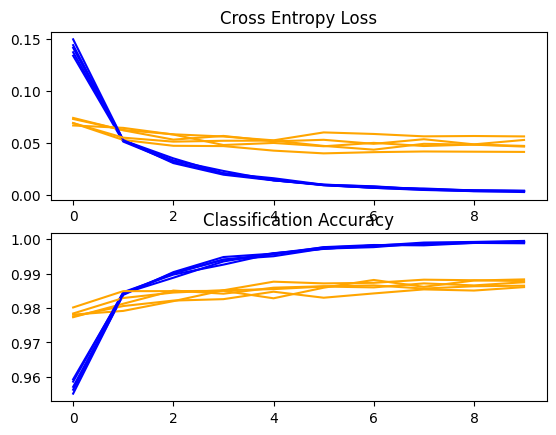

Accuracy: mean=98.725  std=0.094  n=5


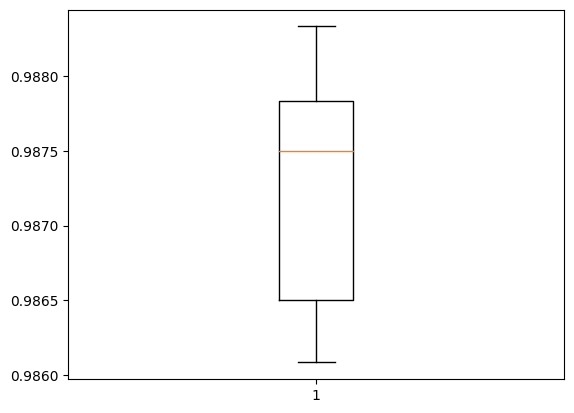

In [16]:
run_test_harness()  # without improving

> 98.508
> 98.583
> 98.600
> 98.833
> 98.775


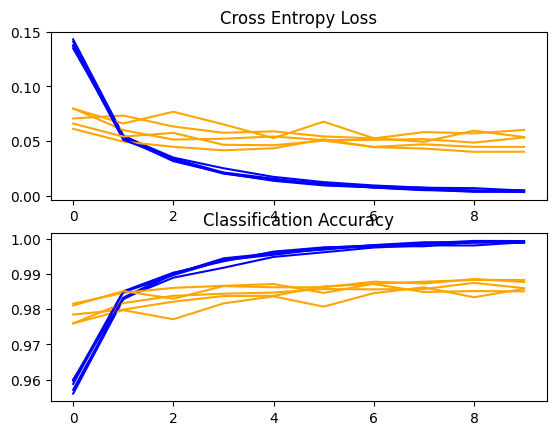

Accuracy: mean=98.660  std=0.138  n=5


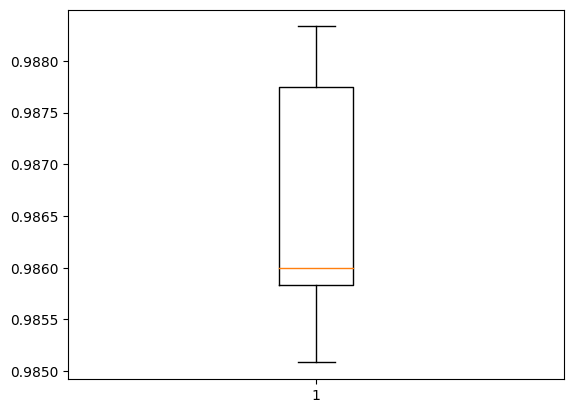

In [17]:
run_test_harness()  # with improving in batch normalization

In [20]:
run_test_harness()  # run the final model with imporvemts in depth too.

# Evaluate Final Model;


In [22]:

def run_test_harness_final_model():
    trainX, _, testX, testy = load_data()
    _, testX = prep_pixels(trainX, testX)

    model = load_model('final_model.h5')

    _, acc = model.evaluate(testX, testy, verbose=0)
    print("Accuracy: %.3f" % (acc*100))


run_test_harness_final_model()

Accuracy: 99.280


In [5]:
# make a prediction for a new image.
from numpy import argmax
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

c:\Users\hima\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


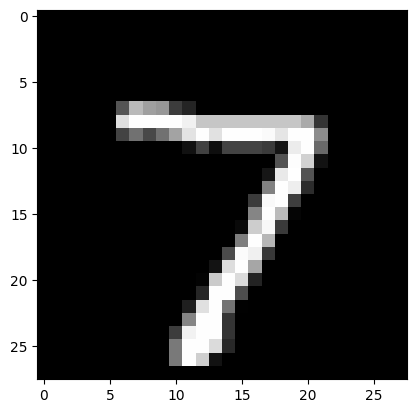

1/1 [==============================] - 0s 138ms/step
Result of this Image: 7


In [19]:
def load_image(path):
    img = load_img(path, grayscale=True, target_size=(28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img /= 255.0
    return img


def run_example(filename, model):
    img = load_image(filename)

    pre_values = model.predict_on_batch(img)
    return argmax(pre_values)


model = load_model('final_model.h5')

res = run_example('imgs\\8.png', model)
print(f"Result of this Image: {res}")

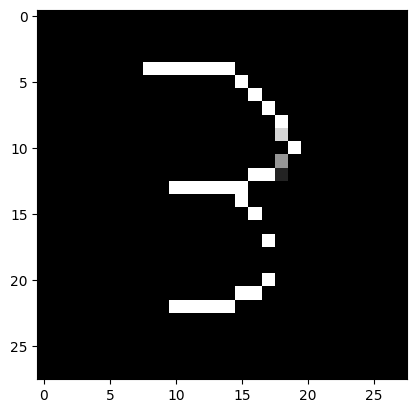

1/1 [==============================] - 0s 45ms/step
Result of this Image: 3


In [20]:
res = run_example('imgs\\3.png', model)
print(f"Result of this Image: {res}")

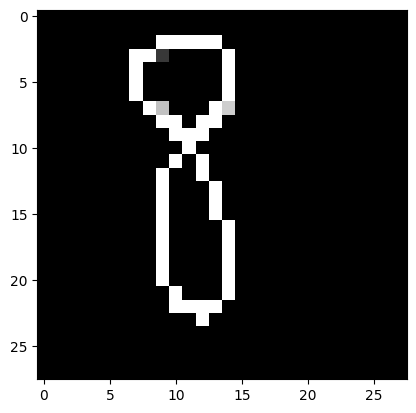

1/1 [==============================] - 0s 36ms/step
Result of this Image: 8


In [23]:
res = run_example('imgs\\8.png', model)
print(f"Result of this Image: {res}")